In [1]:
import pandas as pd 
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors

In [2]:
from read_wandb import wandb_results
api = wandb_results("Strategy_Transfer_TACL")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

FINAL_SWEEP_ID = "64gkgssh"  # ID of the final sweep
TRANSFORMER_SWEEP_ID = "x7qbxqlr"  # ID to run sweep that regenerates the transformer results
COMBINATIONS_SWEEP_ID = "79pczyen"  # ID to run sweep that regenerates the combinations results

In [3]:
def result_metric(sweeps, group_name, drop_list=[], drop_HPT=False, metric=BASE_METRIC, epoch="best", default=False, combinations=False):
    df = api.get_sweeps_results(sweeps, metric=metric) 

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]

    if len(sweeps) == 2:
        transformer_indices = df.index[df['config_final_change'] == "none"][:3]
        df.loc[transformer_indices, 'config_final_change'] = 3

    if default:
        HPT_cols = [col for col in config_cols if df[col].nunique() > 1]
        if len(HPT_cols) == 1:
            HPT_cols = ["config_seed", "config_final_change"]
    else:
        HPT_cols = ["config_seed", "config_final_change"]
        df["config_final_change"] = df["config_final_change"].replace("none", 0)
        df["config_final_change"] = df["config_final_change"].astype(int)


    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]
    
    # Remove non-numeric columns before computing mean and std
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[list(numeric_cols) + [c for c in HPT_cols if c not in numeric_cols]]


    grouped = df_numeric.groupby([c for c in HPT_cols if c != "config_seed"])

    mean_df = grouped.mean()
    std_df = grouped.std()
    
    # Re-add non-numeric columns before computing best_col
    for col in config_cols:
        if col not in mean_df.columns:
            mean_df[col] = df[col]

    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)

    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


def get_run_time(sweeps):
    df = api.get_sweeps_results(sweeps)
    print(df['_runtime'])
    for column in df.columns:
        if "time" in column:
            print(column)


In [4]:
# Create the directory if it doesn't exist
directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)

# Results per epoch

In [5]:
results_per_epoch = [[], [], [], []]

for epoch in range(25):
    sweep_results = result_metric([TRANSFORMER_SWEEP_ID, FINAL_SWEEP_ID], "Final Change", drop_HPT=False, epoch=epoch)
    for i, (_, row) in enumerate(sweep_results.iterrows()):
        results_per_epoch[i].append(row["mean"])

# Plots

## Plots of all experiments

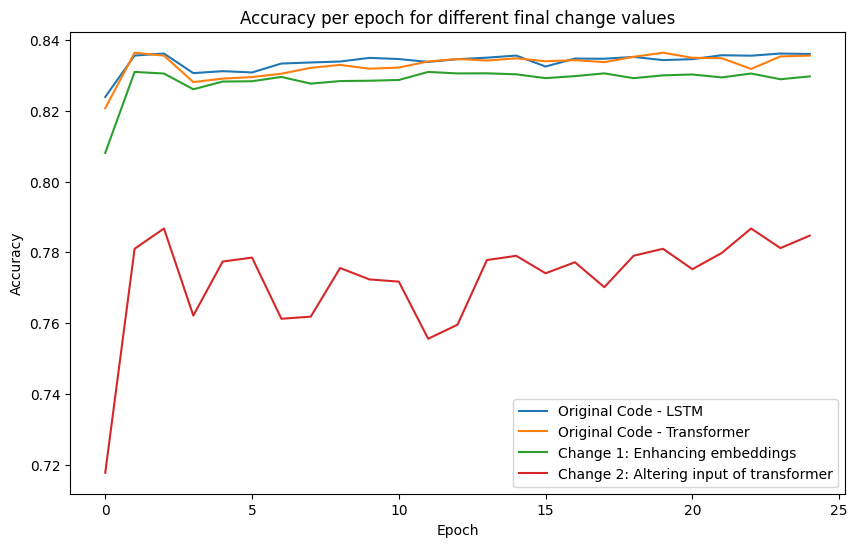

In [6]:

plt.figure(figsize=(10, 6))
plt.plot(results_per_epoch[0], label="Original Code - LSTM")
plt.plot(results_per_epoch[3], label="Original Code - Transformer")
plt.plot(results_per_epoch[1], label="Change 1: Enhancing embeddings")
plt.plot(results_per_epoch[2], label="Change 2: Altering input of transformer")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch for different final change values")
plt.legend()
plt.show()

## Comparing the original LSTM to our embedding improvement

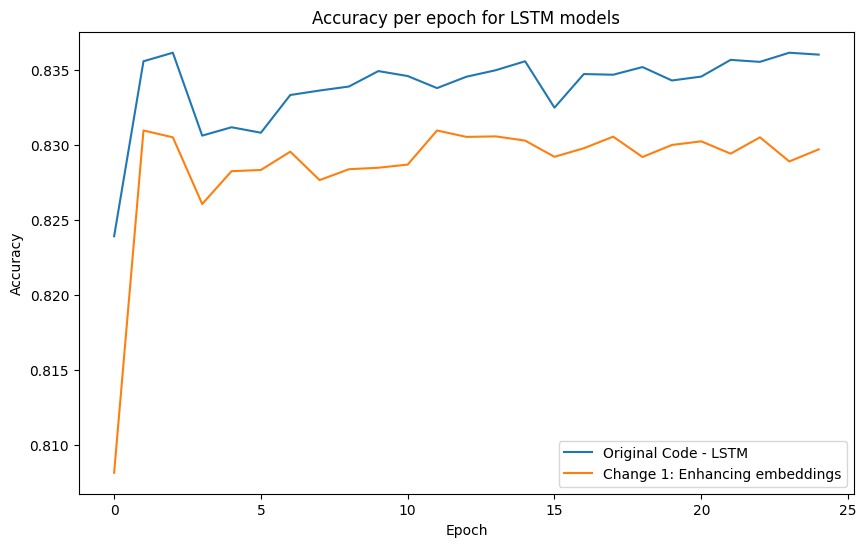

In [7]:
# Compare LSTM to LSTM
plt.figure(figsize=(10, 6))
plt.plot(results_per_epoch[0], label="Original Code - LSTM")
plt.plot(results_per_epoch[1], label="Change 1: Enhancing embeddings")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch for LSTM models")
plt.legend()
plt.show()



## Comparing the original Transformer to the improved architecture

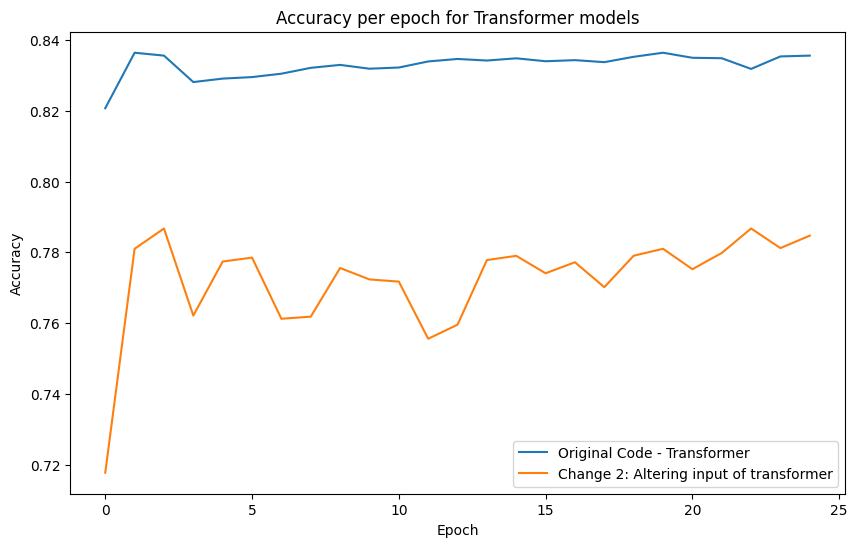

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(results_per_epoch[3], label="Original Code - Transformer")
plt.plot(results_per_epoch[2], label="Change 2: Altering input of transformer")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch for Transformer models")
plt.legend()
plt.show()

In [9]:
# performing score 

sweep_results = result_metric([TRANSFORMER_SWEEP_ID, FINAL_SWEEP_ID], "Final Change", drop_HPT=False, epoch="best")
sweep_results.rename(index={0: "Original LSTM", 1: "Change 1: Altering embeddings", 2: "Change 2: Reshaping input of transformer", 3: "Original Transformer"}, inplace=True)

sweep_results = sweep_results.drop("values", axis=1)
sweep_results = sweep_results.drop("epoch", axis=1)

sweep_results.sort_values("Final Change")

,mean,std,CI
Final Change,,,
Change 1: Altering embeddings,0.830979,0.003834,"(0.8278199639587064, 0.8337304606765723)"
Change 2: Reshaping input of transformer,0.786734,0.005048,"(0.7826345886391965, 0.7904951192594981)"
Original LSTM,0.836174,0.001493,"(0.8350851189562978, 0.8372764584012267)"
Original Transformer,0.836404,0.001643,"(0.8347609934085062, 0.8380463895386526)"


In [10]:
result_metric([ TRANSFORMER_SWEEP_ID, FINAL_SWEEP_ID], group_name="Final Change", metric="_runtime").rename(index={0: "Original LSTM", 1: "Change 1: Altering embeddings", 2: "Change 2: Reshaping input of transformer", 3: "Original Transformer"})

,mean,std,values,epoch,CI
Final Change,,,,,
Original LSTM,7408.678875,51.765660,"[7423.97700381279, 7376.451883792877, 7381.980...",last,"(7374.223305511475, 7454.14006485939)"
Change 1: Altering embeddings,7723.888882,65.470082,"[7684.040640830994, 7811.567120552063, 7670.11...",last,"(7675.685679484605, 7777.684389209748)"
Change 2: Reshaping input of transformer,55845.445952,537.157214,"[55326.98740816116, 56073.33453607559, 55677.0...",last,"(55459.579575967786, 56231.312327051164)"
Original Transformer,17265.761069,386.847854,"[17015.43473672867, 17070.527906179428, 17711....",last,"(17015.43473672867, 17711.320563554764)"


In [11]:
results_per_combination = result_metric([COMBINATIONS_SWEEP_ID], "Final Change", drop_HPT=False, epoch="best", default=True)

idx = results_per_combination.groupby('config_feature_combination')["mean"].idxmax()
results_per_combination.loc[idx]

# df = api.get_sweep_results(COMBINATIONS_SWEEP_ID, metric=BASE_METRIC)
# config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
# cols = [col for col in config_cols if df[col].nunique() > 1]
# df.groupby(cols).max()


,,,mean,std,values,epoch,CI
config_hidden_dim,config_ENV_LEARNING_RATE,config_feature_combination,,,,,
128,0.0010,"['EFs', 'BERT']",0.833179,NaN,[0.8331785545032441],8,"(0.8331785545032441, 0.8331785545032441)"
32,0.0001,"['EFs', 'GPT4']",0.833231,0.001588,"[0.8343544554550333, 0.8321081084273374]",last,"(0.8321081084273374, 0.8343544554550333)"


In [12]:
results_per_combination

mean  \
config_hidden_dim config_ENV_LEARNING_RATE config_feature_combination             
32                0.00001                  ['EFs', 'BERT']             0.808455   
                                           ['EFs', 'GPT4']             0.800795   
                  0.00010                  ['EFs', 'BERT']             0.830898   
                                           ['EFs', 'GPT4']             0.833231   
                  0.00100                  ['EFs', 'BERT']             0.832486   
                                           ['EFs', 'GPT4']             0.831529   
64                0.00001                  ['EFs', 'BERT']             0.814199   
                                           ['EFs', 'GPT4']             0.806086   
                  0.00010                  ['EFs', 'BERT']             0.831679   
                                           ['EFs', 'GPT4']             0.832669   
                  0.00100                  ['EFs', 'BERT']             0.829286   
                                           ['EFs', 'GPT4']             0.830835   
128               0.00001                  ['EFs', 'BERT']             0.819944   
                                           ['EFs', 'GPT4']             0.812655   
                  0.00010                  ['EFs', 'BERT']             0.830160   
                                           ['EFs', 'GPT4']             0.830858   
                  0.00100                  ['EFs', 'BERT']             0.833179   
                                           ['EFs', 'GPT4']             0.831118   

                                                                            std  \
config_hidden_dim config_ENV_LEARNING_RATE config_feature_combination             
32                0.00001                  ['EFs', 'BERT']                  NaN   
                                           ['EFs', 'GPT4']             0.001077   
                  0.00010                  ['EFs', 'BERT']             0.000000   
                                           ['EFs', 'GPT4']             0.001588   
                  0.00100                  ['EFs', 'BERT']             0.005263   
                                           ['EFs', 'GPT4']             0.001906   
64                0.00001                  ['EFs', 'BERT']                  NaN   
                                           ['EFs', 'GPT4']             0.000459   
                  0.00010                  ['EFs', 'BERT']             0.003907   
                                           ['EFs', 'GPT4']             0.000136   
                  0.00100                  ['EFs', 'BERT']             0.001014   
                                           ['EFs', 'GPT4']             0.001018   
128               0.00001                  ['EFs', 'BERT']             0.000138   
                                           ['EFs', 'GPT4']             0.003164   
                  0.00010                  ['EFs', 'BERT']             0.001909   
                                           ['EFs', 'GPT4']             0.001169   
                  0.00100                  ['EFs', 'BERT']                  NaN   
                                           ['EFs', 'GPT4']             0.000192   

                                                                                                                  values  \
config_hidden_dim config_ENV_LEARNING_RATE config_feature_combination                                                      
32                0.00001                  ['EFs', 'BERT']                                          [0.8084549025925566]   
                                           ['EFs', 'GPT4']             [0.8014166132081877, 0.8014166132081877, 0.799...   
                  0.00010                  ['EFs', 'BERT']                        [0.830897638256088, 0.830897638256088]   
                                           ['EFs', 'GPT4']                      [0.8343544554550333, 0.8321081084273374]   
         